# Problem Statement

The goal of this project is to discover and extract meaningful topics from large collections of texual data, such as Amazon reviews, using topic modeling. By analyzing the text of the reviews, topic modeling algorithms can identify the underlying patterns and group together similar reviews that revolve around common topics. This enables us to gain insights into the main subjects of discussion within the reviews, allowing us to understand customer preferences, identify product strengths and weaknesses, and perform market research.

Reference resource: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing#scrollTo=_ak_CLR164mx

# Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import gzip
import json
import itertools
import seaborn as sns

# topic modeling
import os
import pandas as pd
try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Part 1: Extracting the Data

### Dataset #1

In [ ]:
# identify the ASINs associated with products from Nike
# extract of sales rank
asins = []
sales_ranks = {}
with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.json.gz") as products:
  for product in products:
    data = json.loads(product)
    categories = itertools.chain(*data.get("categories", []))
    categories = [c.lower() for c in categories]
    if "nike" in categories:
      asins.append(data["asin"])
      if data.get("salesRank"):
        sales_ranks[data["asin"]] = list(data["salesRank"].items())[0][1]


In [ ]:
# the length of asins will tell us how many we have:
len(asins)

8327

In [ ]:
# inspect a few:
asins[:3]

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46']

In [ ]:
# the length of sales_rank will tell us how many we have:
len(sales_ranks)

7962

In [ ]:
# inspect the first few items of sale_rank
dict(list(sales_ranks.items())[:3])

{'B0000V9K32': 67039, 'B0000V9K3W': 102054, 'B0000V9K46': 116131}

In [ ]:
import operator
# sort the sales_ranks in descending order based on the values
ordered_asin_ranks = sorted(sales_ranks.items(), key=operator.itemgetter(1))

In [ ]:
# top 10 asin_ranks
ordered_asin_ranks[:10]

[('B00EQBFL62', 179),
 ('B00EQBEWMQ', 179),
 ('B00EQBEUXC', 179),
 ('B00EQBGOTA', 179),
 ('B006RBH2PW', 188),
 ('B00AMTY3UC', 209),
 ('B00D8M3Q3U', 272),
 ('B00527DJAY', 318),
 ('B00527DIXW', 318),
 ('B00BUDLR1C', 337)]

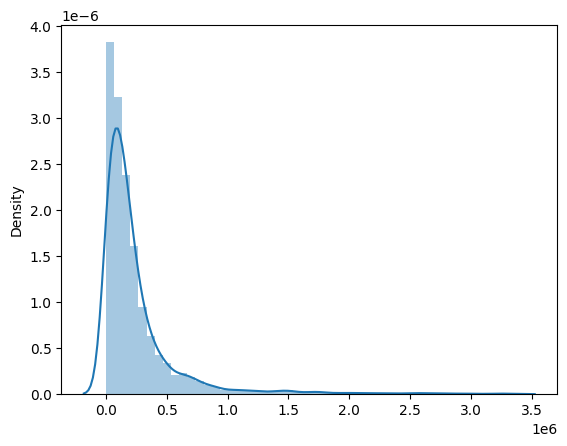

In [ ]:
plot = sns.distplot(list(sales_ranks.values()))
#plot = sns.histplot(list(sales_ranks.values()))

We can see here that there is quite a long tail of low-ranking products, i.e. large values going to the right on the x-axis. Some of these rankings are low enough that Seaborn has plotted at a scale of 1 x 10^6. It looks like our lowest ranking product ranks as about the 3.5 millionth best selling product in it's category!

We can verify this simply by looking at the last item of the ordered list we produced above:

In [ ]:
ordered_asin_ranks[-1]

('B000AYI6FC', 3341111)

At a glance, we can see that the bulk of our ranked products, however, fall into the range of 0 to 3000, where 3000 is indicated as 0.5 x 1x10^6.

For purposes of analysis, then, let's create a filtered subset of the list that contains only ASINs of products with a sales rank of 3000 or better.

In [ ]:
best_asins = [asin for asin, rank in sales_ranks.items() if rank <= 3000]

In [ ]:
# inspect a few items
best_asins[:3]

['B0001LGWEQ', 'B000G42Z2Q', 'B000RDFRIK']

In [ ]:
# check the length
len(best_asins)

274

### Dataset #2

In [ ]:
# build a corpus of review texts:
review_corpus = []
top_reviews = {}
with gzip.open("drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz") as reviews:
  for i, review in enumerate(reviews):
    review = json.loads(review)
    _id = "%s.%s" % (review["asin"], review["reviewerID"])
    if review["asin"] in asins:
      review_corpus.append(review["reviewText"])
    if review["asin"] in best_asins:
      top_reviews[_id] = review


In [ ]:
len(review_corpus)

21570

In [ ]:
#inspect a few of the reviews:
for i, review in enumerate(review_corpus[:5]):
  print(i, review[:100])

0 the colour i received is not blue as shown but yellow.Couldnt change it because it was a birthday pr
1 Very cute and is really practical. Fits better on smaller wrists which is my case. I wear them every
2 The watch was exactly what i ordered and I got it very fast. Unfortunately it was a bit too big for 
3 This product came promptly and as described, pleasure doing business with them!-d
4 Why isn't Nike making these anymore?  I love this watch, and I get a lot of compliments, questions f


In [ ]:
len(top_reviews)

3549

In [ ]:
# load the texts of the top reviews into a list
texts = []
for k, v in top_reviews.items():
    texts.append(v["reviewText"])

In [ ]:
len(texts)

3549

In [ ]:
# inspect a few of the top reviews:
texts[:5]

["I've had this watch for over a year now and wear it daily. I love it and the features it provides.",
 "Although I'm rarely a fan of Nike, I bought this pair to try it out and i absolutely liked it. Very suitable for causal wear, but I'm not sure how good of a running pair this one is. I got the dark grey color with florescent green stripes.Overall very cool pair",
 'i love this shoes  great price good quality',
 'I ordered this just before my last Europe trip. I ordered it last minute and arrived at time and fits well. However one of the lace loops ripped on the third day of wearing (even before walking 10 miles........oh no after 5000 miles...I was wearing it in the plane). Fortunately my friend there had an extra pair of sneakers which fitted my foot well. Immediately after returning from my trip I sent them back and got the refund in two days. This one star is for their order handling and easy return procedure.',
 "Because the look and feel of the sneakers are awesome. It's a perf

# Part 2: Implement a pre-processor

Here I will implement a function called `clean_text` which will take a list of texts and return a clean_text. Preprocessing should include the following actions:
 - lemmatize the texts
 - convert tokens to lowercase
 - remove special characters
 - clean tokens to remove numbers and any tokens shorter than 3 characters

In [ ]:
def clean_text(text):

  # tokenize the text
  tokens = word_tokenize(text)
  # initialize WordNetLemmatizer
  lemmatizer = WordNetLemmatizer()
  # lemmatize the tokens
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  # convert tokens to lowercase
  lowercase_tokens = [token.lower() for token in lemmatized_tokens]
  # remove special characters and tokens shorter than 3 characters
  cleaned_tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in lowercase_tokens if len(token) > 2 and not token.isdigit()]

  return cleaned_tokens

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
preprocessed_texts = []
for text in texts:
  cleaned_text = clean_text(text)
  preprocessed_texts.append(" ".join(cleaned_text))

In [ ]:
# view a few text after cleaning
preprocessed_texts[:5]

['ve had this watch for over year now and wear daily love and the feature provides',
 'although rarely fan nike bought this pair try out and absolutely liked very suitable for causal wear but not sure how good running pair this one got the dark grey color with florescent green stripesoverall very cool pair',
 'love this shoe great price good quality',
 'ordered this just before last europe trip ordered last minute and arrived time and fit well however one the lace loop ripped the third day wearing even before walking mile  after mile  wearing the plane fortunately friend there had extra pair sneaker which fitted foot well immediately after returning from trip sent them back and got the refund two day this one star for their order handling and easy return procedure',
 'because the look and feel the sneaker are awesome perfect fit and support for foot']

# Part 3: Performing Topic Modeling

We will go through the main components of BERTopic and the steps necessary to create a strong topic model.

## 3.1 Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language.
We will also calculate the topic probabilities.

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(preprocessed_texts)

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

2023-06-22 13:44:12,245 - BERTopic - Transformed documents to Embeddings
2023-06-22 13:44:29,991 - BERTopic - Reduced dimensionality
2023-06-22 13:44:30,549 - BERTopic - Clustered reduced embeddings


## Extracting Topics

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents.

In [ ]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1192,-1_shoe_the_and_they,"[shoe, the, and, they, for, them, these, are, ...",[already had pair black nike thong that love a...
1,0,363,0_running_shoe_for_run,"[running, shoe, for, run, and, are, these, gre...","[good for running, hands down the best shoe an..."
2,1,238,1_sandal_these_are_the,"[sandal, these, are, the, and, they, foot, the...",[the look the sandal are little different than...
3,2,122,2_comfortable_they_fit_them,"[comfortable, they, fit, them, very, and, are,...",[got these for wife she very happy with them s...
4,3,97,3_wide_narrow_foot_shoe,"[wide, narrow, foot, shoe, but, for, width, th...",[these shoe look nice and are almost the same ...


-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [ ]:
# select the most frequent topic
topic_model.get_topic(0)

[('running', 0.03768571116732423),
 ('shoe', 0.02103170348159069),
 ('for', 0.020550331186773078),
 ('run', 0.019521367868231276),
 ('and', 0.01760348818464667),
 ('are', 0.015919454332891433),
 ('these', 0.015457309201407202),
 ('great', 0.015007106350517697),
 ('gym', 0.014858467476397803),
 ('they', 0.013733460895444303)]

In [ ]:
topic_model.topics_[:10]

[-1, 0, -1, -1, -1, 5, 3, 6, 2, 0]

In [ ]:
# the size of each topic
list(topic_model.topic_sizes_.items())[:10]

[(-1, 1192),
 (0, 363),
 (5, 78),
 (3, 97),
 (6, 76),
 (2, 122),
 (23, 29),
 (9, 68),
 (11, 57),
 (30, 24)]

In [ ]:
# how many topic we have
len(topic_model.topic_sizes_)

53

In [ ]:
# get the default label for each topic
list(topic_model.topic_labels_.items())[:10]

[(-1, '-1_shoe_the_and_they'),
 (0, '0_running_shoe_for_run'),
 (1, '1_sandal_these_are_the'),
 (2, '2_comfortable_they_fit_them'),
 (3, '3_wide_narrow_foot_shoe'),
 (4, '4_squeak_squeaking_powder_loud'),
 (5, '5_nike_and_this_the'),
 (6, '6_sneaker_fit_these_love'),
 (7, '7_slide_are_velcro_the'),
 (8, '8_son_his_size_daughter')]

In [ ]:
# the representative documents for each topic
list(topic_model.representative_docs_.items())[1:5]

[(0,
  ['good for running',
   'hands down the best shoe and most comfortable shoe ve ever worn these shoe are very light very softcomfortable and also great foot support for those that have flat foot not much runner but when tried first time running these shoe felt running pillow for mile love these shoe and will start buying more pair want try using them when play basketball but nt want get shoe dirty although very tempting try definitely recommend these shoe for everyday use running',
   'these are like walking air have pair this style and can say that have never had better pair running shoe they are light your foot like you nt have shoe and yet are soft walk did buy 12 size larger than normal running shoe']),
 (1,
  ['the look the sandal are little different than the picture when got mine ordered white symbol nike sandal and received black one not only that received two different size sandal least the sandal felt comfortable',
   'these sandal were perfect have pair these sandal th

## Visualization

There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created.

### Visualize Topics

After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to [LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
topic_model.visualize_topics()

Intertopic distance map measures the distance between topics. Similar topics are closer to each other, and very different topics are far from each other. From the visualization, we can see that there are eight topic groups for all the topics. Topics with similar semantic meanings are in the same topic group.

The size of the circle represents the number of documents in the topics, and larger circles mean that more reviews belong to the topic.

### Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

### Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, we can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

The length of the bar represents the score of the keyword. A longer bar means higher importance for the topic.

### Visualize Topic Similarity

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

Heatmap can also be used to analyze the similarities between topics. The similarity score ranges from 0 to 1. A value close to 1 represents a higher similarity between the two topics, which is represented by darker blue color.

### Visualize Topic Probabilities

The variable probabilities that is returned from transform() or fit_transform() can be used to understand how confident BERTopic is that certain topics can be found in a document. The min_probability parameter is used to control the minimum probability threshold for displaying topics in the visualization. It determines the minimum probability that a topic must have in order to be included in the visualization.

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
topic_model.visualize_distribution(probs[300], min_probability=0.02)

From above figure, we can see the topic probability distribution for the review with index 300 in the dataset shows that topic 31 has the highest probability, so topic 31 is the predicted topic.

### Visualize Term Score Decline

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing#scrollTo=_ak_CLR164mx

In [ ]:
topic_model.visualize_term_rank()

## 3.2 Training New Topic Model

After having created the topic model, now I would like to remove stopwords and create a new instance of "BERTopic" and fit the updated model on the texts_without_stopwords.

In [ ]:
# remove stopwords from texts
stopwords = set(stopwords.words('english'))
texts_without_stopwords = []

for text in preprocessed_texts:
  tokens = word_tokenize(text)
  tokens_without_stopwords = [token for token in tokens if token not in stopwords]
  texts_without_stopwords.append(" ".join(tokens_without_stopwords))


In [ ]:
# create new_topic_model
new_topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = new_topic_model.fit_transform(texts_without_stopwords)

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

2023-06-22 13:56:22,966 - BERTopic - Transformed documents to Embeddings
2023-06-22 13:56:36,869 - BERTopic - Reduced dimensionality
2023-06-22 13:56:37,343 - BERTopic - Clustered reduced embeddings


In [ ]:
# get 5 most frequent topics
new_freq = new_topic_model.get_topic_info()
new_freq.head(5)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1232,-1_shoe_size_nike_comfortable,"[shoe, size, nike, comfortable, foot, fit, pai...",[bought pair store close house pink absolutely...
1,0,210,0_sandal_foot_comfortable_would,"[sandal, foot, comfortable, would, pair, wear,...",[sandal perfect pair sandal best sandal buy mo...
2,1,204,1_son_gift_love_bought,"[son, gift, love, bought, birthday, grandson, ...",[bought year old son fit true size love say co...
3,2,142,2_color_love_shoe_comfortable,"[color, love, shoe, comfortable, light, pink, ...",[nice lightweight really comfortable shoe thin...
4,3,128,3_fit_great_shirt_look,"[fit, great, shirt, look, well, comfortable, p...","[great fit, fit well comfortable look great, f..."


In [ ]:
# select the most frequent topic
new_topic_model.get_topic(0)

[('sandal', 0.10784979202800266),
 ('foot', 0.01723310798235316),
 ('comfortable', 0.015306289314635768),
 ('would', 0.014867328836780535),
 ('pair', 0.01395514415795618),
 ('wear', 0.012942521613101011),
 ('strap', 0.012757696570030171),
 ('great', 0.0125781159475257),
 ('fit', 0.012533385740032451),
 ('love', 0.01212194775855453)]

In [ ]:
# how many topic we have
len(new_topic_model.topic_sizes_)

52

In [ ]:
# Visualize Topics
new_topic_model.visualize_topics()

In [ ]:
# visualize topic hierarchy
new_topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
# visualize terms
new_topic_model.visualize_barchart(top_n_topics=20)

In [ ]:
# visualize topic similarity
new_topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
new_topic_model.visualize_distribution(probs[200], min_probability=0.015)

From above figure, we can see the topic probability distribution for the review with index 200 in the dataset shows that topic 0 has the highest probability, so topic 0 is the predicted topic.

## 3.3 Update Topic Model

Next, want to try out a different n_gram_range. We can use the function update_topics to update the topic representation with new parameters for c-TF-IDF.

In [ ]:
new_topic_model.update_topics(texts_without_stopwords, n_gram_range=(1,2))

In [ ]:
# select the most frequent topic
new_topic_model.get_topic(0)

[('sandal', 0.07397483846756235),
 ('nike sandal', 0.014298656477779597),
 ('foot', 0.013201347823052165),
 ('comfortable', 0.012006408255020827),
 ('would', 0.010723665027620803),
 ('pair', 0.010512909831834732),
 ('comfortable sandal', 0.00978741515748314),
 ('fit', 0.00972140505673235),
 ('great', 0.009673340974039676),
 ('wear', 0.009638643730081903)]

## 3.4 Topic Reduction


We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so,
is that you can decide the number of topics after knowing how many are actually created. It is difficult to
predict before training your model how many topics that are in your documents and how many will be extracted.
Instead, we can decide afterwards how many topics seems realistic:


In [ ]:
new_topic_model.reduce_topics(texts_without_stopwords, nr_topics=40)

2023-06-22 14:06:48,901 - BERTopic - Reduced number of topics from 52 to 40


In [ ]:
# Access the newly updated topics with:
print(new_topic_model.topics_)

[2, -1, 22, 0, -1, 27, -1, -1, 2, -1, 23, -1, -1, -1, -1, -1, -1, 3, 1, -1, 5, -1, 6, 6, -1, 4, 4, 3, 2, 4, -1, -1, -1, 2, -1, 6, 21, -1, 6, 12, -1, 12, 9, 15, -1, -1, 0, -1, 7, 26, 10, 3, 2, 15, 31, 30, -1, 3, -1, -1, 0, 2, 2, -1, 2, 0, 9, 6, -1, 0, -1, 18, 30, -1, 0, 3, 7, 0, 2, -1, 3, 24, 0, 17, 18, -1, 0, 23, 0, -1, -1, -1, -1, 6, -1, -1, 2, -1, -1, -1, 2, -1, 15, 22, -1, 12, -1, 6, -1, -1, 5, 2, -1, -1, -1, 27, -1, 0, -1, 9, 10, -1, 9, 15, 14, 0, 0, 2, -1, 12, 0, 7, -1, 26, -1, 8, 4, -1, 2, 1, -1, -1, -1, 7, 1, 3, 1, 0, 5, 1, -1, -1, 18, 3, 3, 7, 1, 20, 2, 38, -1, 38, 11, 0, 7, 3, -1, 5, 7, 1, -1, 12, 1, 2, 1, -1, 1, 7, 20, -1, 17, 0, 1, 31, 1, 1, 16, 7, -1, 1, -1, 1, 2, -1, 1, 7, 1, 33, 2, 14, 1, -1, 2, 0, 10, 11, 1, -1, 2, -1, 2, 7, 20, 1, 13, 5, 1, 0, 7, 19, 1, 17, 20, 7, -1, 7, 0, 20, 1, 14, 20, 1, 7, 1, 7, 2, 11, -1, 5, 16, -1, -1, 7, 3, 1, 20, -1, -1, 7, -1, 7, 1, 1, -1, 37, 17, 1, 7, 0, 11, 3, 2, 3, 1, 5, 16, 1, 21, 25, 20, 2, 2, 2, 5, 26, -1, 5, 19, 3, -1, 1, 1, 20, 25, 1,

In [ ]:
# search for topics that are similar to an input search_term
similar_topics, similarity = new_topic_model.find_topics("watch", top_n=5)
similar_topics

[38, 3, 33, 19, 6]

In [ ]:
new_topic_model.get_topic(38)

[('came', 0.05301583465077054),
 ('expected', 0.04121037591354496),
 ('exact', 0.03798275781218034),
 ('fit', 0.0361100323990331),
 ('look like', 0.03261186805535298),
 ('fit expected', 0.03226113358800571),
 ('time', 0.03158208786471383),
 ('product', 0.03109714980869899),
 ('width arrived', 0.02967980290715887),
 ('make many', 0.02967980290715887)]

In [ ]:
# visualize topics
new_topic_model.visualize_topics()

In [ ]:
# visualize topic hierarchy
new_topic_model.visualize_hierarchy(top_n_topics=40)

In [ ]:
list(new_topic_model.representative_docs_.values())[10]

['like sneaker comfortable fit well looking pair sneaker every day use get',
 'love love sneaker fit great comfort excellent would recommend sneaker ladies',
 'love sneaker fit great comfortable next sneaker walking sneaker wear size 115']

When it comes to sneakers, it's clear that consumers often mention comfort as a key factor, especially for everyday use and walking. Therefore, we should highlight these attributes in our advertising campaigns for sneakers.

In [ ]:
# visualize terms
new_topic_model.visualize_barchart(top_n_topics=10)

Looking at topic word scores above, we can see that: the word “comfortable” frequently appears across different types of shoes, indicating that comfort is a key attribute we can emphasize in our advertising campaigns.

In [ ]:
# visualize topic similarity
new_topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

Looking at similarity matrix above, we can see that topic 29 and topic 2 have a high similarity score of 0.72, so let's looking at these topic:

In [ ]:
list(new_topic_model.representative_docs_.values())[30]

['great comfy shoe daughter love lightweight shoe planning getting pair love great new color',
 'daughter say walk look sexy sneaker comfortable bought daughter pair christmas',
 'bought daughter black white slide birthday started looking color option one picked adorable complaint get pink dirty nt get clean however comfortable slide market daughter couple pair highly recommened style comfort']

In [ ]:
list(new_topic_model.representative_docs_.values())[3]

['year old son love shoe fit perfectly say extremely comfortable highly recommend',
 'bought year old son fit true size love say comfortable',
 'bought shoe gray orange son active old boy already men size shoe free runs nt cheap birthday gift nt mind really wanted son say comfortable look nice reason star one week toe started wear gray toe tip wearing white one month toe entirely fell apart sports authority bought said son nt using right activity clearly look like dragged foot bike son nt riding bike wear school 34 time per max doe nt wear school soccer basketball practice wear shoe damage one month school wear doe nt recess time per would buy shoe child']

We can see that topic 2 and 29 shows that consumers often buy Nike shoes as gifts, particularly for sons and daughters on Chirstmas or birthday. This understanding can guide us in selecting appropriate advertising media and timing our campaigns effectively.

In [ ]:
# Save model
new_topic_model.save("my_model")

In [ ]:
# Load model
my_model = BERTopic.load("my_model")

# Conclusion

The analysis of Amazon reviews using topic modeling has provided valuable insights into customer preferences and sentiments, greatly enhancing our understanding of the market. By identifying the main topics discussed by customers, we have gained important knowledge about what they like, dislike, and what matters most to them. This information can be directly applied to improve products, develop effective marketing strategies, and enhance overall customer satisfaction. For instance, through topic modeling, we can infer:

- Attributes that people like about our products
For example, the word “comfortable” frequently appears across different types of shoes, indicating that comfort is a key attribute we can emphasize in our advertising campaigns. Additionally, when it comes to sneakers, it's clear that consumers often mention comfort as a key factor, especially for everyday use and walking. Therefore, we should highlight these attributes in our advertising campaigns for sneakers.

- Purchase Occasions
Topic 2 and 29 shows that consumers often buy Nike shoes as gifts, particularly for sons and daughters on Chirstmas or birthday. This understanding can guide us in selecting appropriate advertising media and timing our campaigns effectively.

